## Google Playstore Apps Raiting Prediction

In [1]:
# Data
import numpy as np
import pandas as pd
from collections import defaultdict

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the cleaned CSV file
df_apps = pd.read_csv(r"../data/Google-Playstore-Dataset-Clean.csv")
print(df_apps.head())

                App Name      Category Installs  Size Minimum Android  \
0                Gakondo     Adventure      10+   10M      7.1 and up   
1    Ampere Battery Info         Tools   5,000+  2.9M      5.0 and up   
2                 Vibook  Productivity      50+  3.7M    4.0.3 and up   
3                 IMOCCI        Social      50+   46M      6.0 and up   
4  The Everyday Calendar     Lifestyle     500+   16M      5.0 and up   

       Released  Last Updated Content Rating  Rating  Minimum Installs  \
0  Feb 26, 2020  Feb 26, 2020       Everyone     0.0                10   
1  May 21, 2020  May 06, 2021       Everyone     4.4               100   
2   Aug 9, 2019  Aug 19, 2019       Everyone     0.0                50   
3  Dec 24, 2018  Dec 20, 2019           Teen     0.0                50   
4  Jun 21, 2019  Jun 21, 2019       Everyone     2.0               500   

   Maximum Installs  
0                15  
1              7662  
2                58  
3                89  
4     

Codification of categorical variables and data splitting for modeling


In [3]:
df_apps['Installs'] = pd.factorize(df_apps['Installs'])[0].astype(int)

In [4]:
# Remove columns that do not add value to the model
ignore_columns = ['App Name', 'Released', 'Minimum Android']
df_predic = df_apps.drop(columns=ignore_columns)

In [5]:
# Define X and Y variables for prediction: 'Rating' will be the dependent variable, which will be predicted.
x = df_predic.drop(columns=['Rating'])
y = df_predic['Rating']  

In [6]:
# Transform categorical variables into integers, assigning each category a unique value.
encoder = LabelEncoder()
for column in x.columns:
    if x[column].dtype == 'object': 
        x[column + '_encoded'] = encoder.fit_transform(x[column])  

x_encoded = x.drop(columns=x.select_dtypes(include=['object']).columns)

In [7]:
scaler = StandardScaler()
x_encoded['Installs'] = scaler.fit_transform(x_encoded[['Installs']])

In [8]:
# Divide data into 80% for training and 20% for testing

x_train_encoded, x_test_encoded, y_train, y_test = train_test_split(x_encoded, y, test_size=0.2, random_state=42)

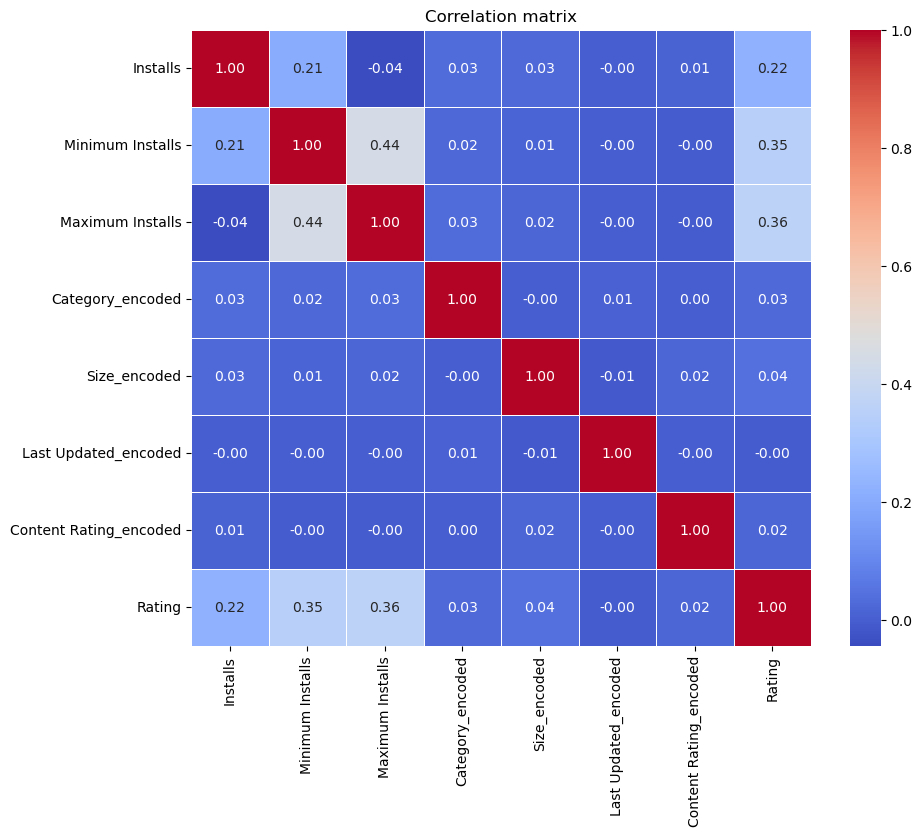

In [9]:
# Correlation matrix
matrix_corr = pd.concat([x_train_encoded, y_train], axis=1)
correlation_matrix = matrix_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation matrix')
plt.show()

In [10]:
# Standardize the variables
scaler = StandardScaler()
x_train_sc = scaler.fit_transform(x_train_encoded)
x_test_sc = scaler.transform(x_test_encoded)

### Classification Model


In [11]:
# Convert 'rating' to a discrete variable
y_train_int = y_train.astype(int)
y_test_int = y_test.astype(int)

In [12]:
# Create dataframes to save metrics
models = ['Logistic Regression', 'Random Forest']
datasets = ['train', 'test']

multi_index = pd.MultiIndex.from_product([models, datasets],
                                         names=['model', 'dataset'])

df_metrics_clf = pd.DataFrame(index=multi_index,
                          columns=['accuracy %'])

In [13]:
df_metrics_clf

accuracy %
model               dataset           
Logistic Regression train          NaN
                    test           NaN
Random Forest       train          NaN
                    test           NaN

#### Logistic Regression Classifier

In [14]:
# Train the logistic regression model with training data
model_logistic = LogisticRegression()
model_logistic.fit(x_train_sc, y_train_int)

LogisticRegression()

In [15]:
df_metrics_clf.loc['Logistic Regression', 'train'] = model_logistic.score(x_train_sc, y_train_int)
df_metrics_clf.loc['Logistic Regression', 'test'] = model_logistic.score(x_test_sc, y_test_int)
print(df_metrics_clf)

                            accuracy %
model               dataset           
Logistic Regression train     0.610029
                    test      0.610856
Random Forest       train          NaN
                    test           NaN


#### Random Forest Classifier

In [80]:
# Train the Random Forest Classifier model with training data
model_rf = RandomForestClassifier()
model_rf.fit(x_train_sc, y_train_int)

RandomForestClassifier()

In [81]:
df_metrics_clf.loc['Random Forest', 'train'] = model_rf.score(x_train_sc, y_train_int)
df_metrics_clf.loc['Random Forest', 'test'] = model_rf.score(x_test_sc, y_test_int)
print(df_metrics_clf)

                             accuracy %
model               dataset            
Logistic Regression train     61.000000
                    test      61.090000
Random Forest       train      0.996956
                    test       0.661464


#### Classification Evaluation

In [82]:
df_metrics_clf['accuracy %'] = df_metrics_clf['accuracy %'].apply(lambda v: round(v*100, ndigits=2))
df_metrics_clf

accuracy %
model               dataset            
Logistic Regression train       6100.00
                    test        6109.00
Random Forest       train         99.70
                    test          66.15

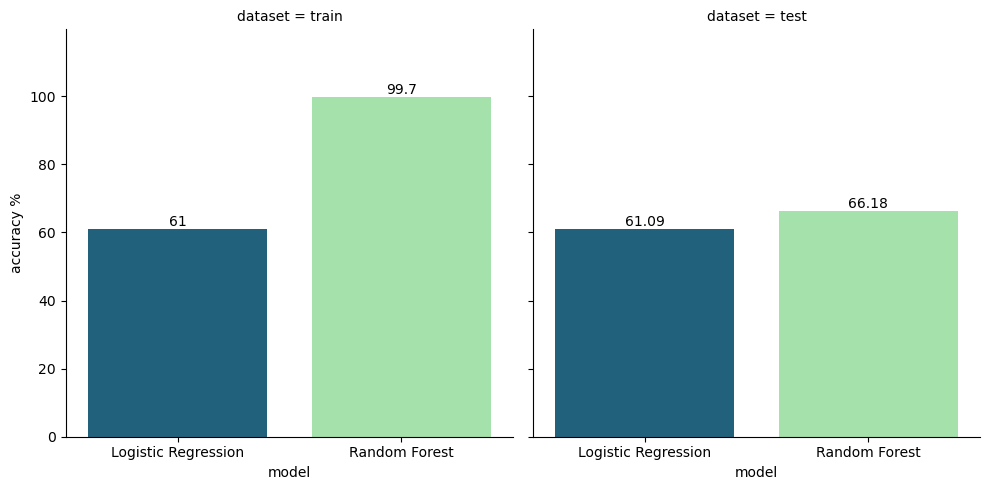

In [19]:
colors = {'Blue': '#13678A', 'Green': '#9AEBA3'}
data = df_metrics_clf.reset_index()

g = sns.catplot(col='dataset', data=data, kind='bar', x='model', y='accuracy %', palette=colors.values())

for ax in g.axes.ravel():
    for c in ax.containers:
        ax.bar_label(c, label_type='edge')
    ax.margins(y=0.2)
plt.show()


Confusion Matrix

In [83]:
x_train_encoded,x_test_encoded,y_train,y_test = train_test_split(x,y,stratify=y,test_size=0.3,random_state=20)
x_train_encoded.shape,x_test_encoded.shape,y_train.shape,y_test.shape

((740264, 11), (317257, 11), (740264,), (317257,))

In [96]:
model_rf = RandomForestClassifier()
model_rf.fit(x_train_sc, y_train_int)
y_pred = model_rf.predict(x_test_sc)
rf_acc = accuracy_score(y_pred,y_test_int)*100
print("Accuracy =",round(rf_acc,2),"%")
cm = confusion_matrix(y_pred,y_test_int)

Accuracy = 66.17 %


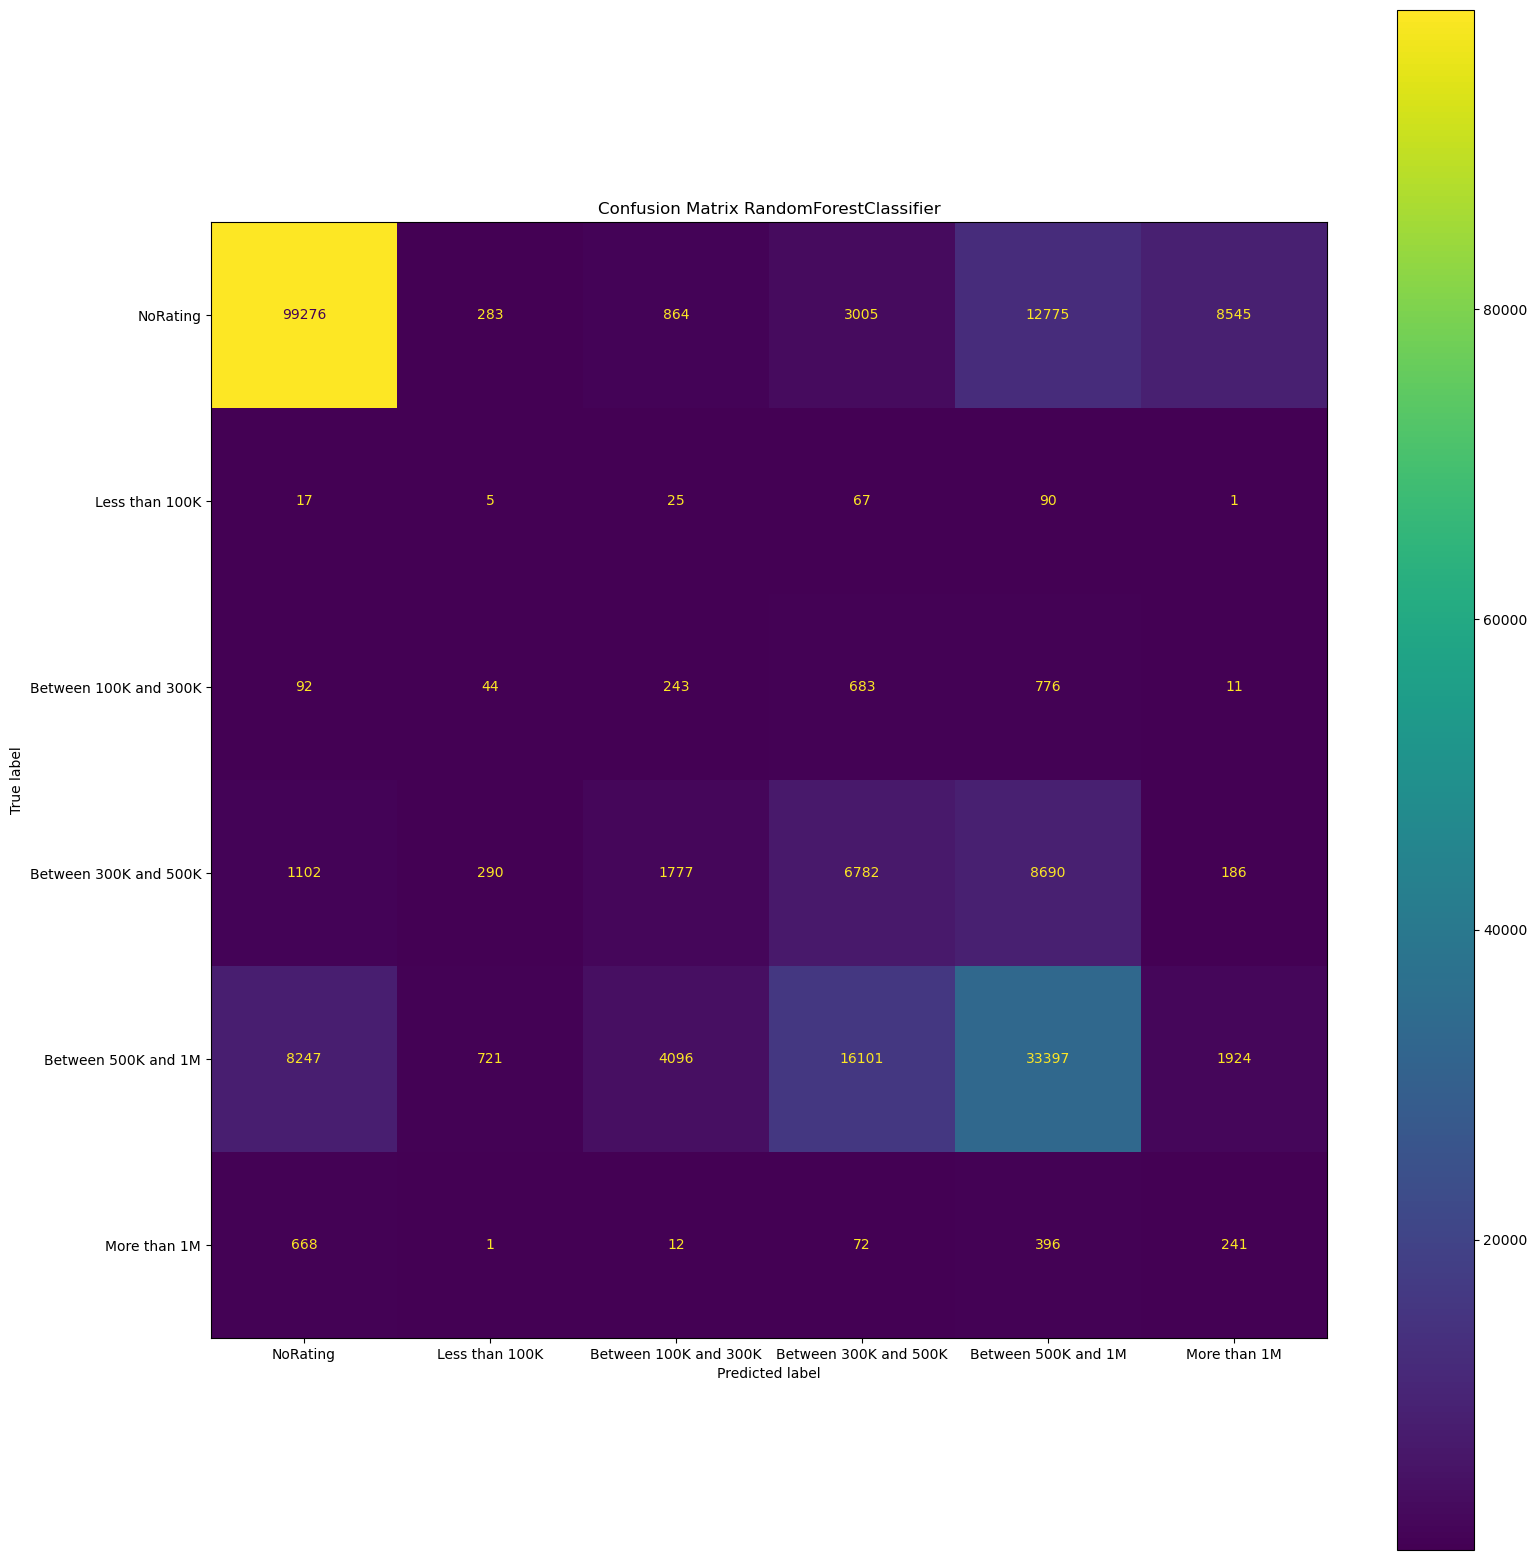

In [99]:

cmd = ConfusionMatrixDisplay(cm,display_labels=['NoRating', 'Less than 100K', 'Between 100K and 300K', 'Between 300K and 500K', 'Between 500K and 1M', 'More than 1M'])
fig, ax = plt.subplots(figsize=(18,20));
plt.title("Confusion Matrix RandomForestClassifier")
cmd.plot(ax=ax);